# Preprocessing GIS Data for RHESsys Model on Collaborative Modeling Framework

## 1) Objective

- Background

 1. Hydrologic models are growing in complexity: spatial representations, model coupling, process representations, software structure etc.
 2. New and emerging datasets are growing, supporting even more detailed modeling use cases.
 3. This complexity is leading to reproducibility crisis in hydrologic modeling and analysis.
 4. We argue that moving modeling to the cloud can help to address this reproducibility crisis.

This notebook demonstrates the process of collecting and manipulating GIS data using GRASS GIS, Python and R to create RHESsys Model input.

This notebook include:

1. Creating Project Directory and Download Raw GIS Data from HydroShare
2. Setting GRASS Database and GISbase Environment
3. Importing and Processing DEM
4. Importing and Processing NLCD Map
5. Importing and Processing Soil Map
6. Importing and Processing Road network/Isohyet
7. Construct worldfile and flowtable to RHESSys

## 2) Study Area: Coweeta subwatershed 18, NC, USA

<img src="coweeta_sub18.png">

## 3) Creating Project Directory and Download Raw GIS Data from HydroShare

### 3-1) Set the project directory

In [1]:
import os
# Define project and watershed name
PROJNAME='RHESsys_preprocessing' 
WATERSHED='coweeta_sub18'
# Define project directory
PROJDIR = os.path.join(os.getcwd(), PROJNAME)
# Define raw GIS and observation data directory downloaded from HydroShare
RAWGISDIR = os.path.join(PROJDIR, "raw_data")
# Define RHESsys model iput directory
RHESSysDIR = os.path.join(PROJDIR, 'model')
# Define source code directory to use preprocessing from GitHub
RLIB = os.path.join(PROJDIR, 'RLIB')

In [2]:
# Create directories if directories are not previously setup.
if not os.path.exists(PROJDIR):
    os.mkdir(PROJDIR)
    os.mkdir(RAWGISDIR)
    os.mkdir(RHESSysDIR)
    os.mkdir(RLIB)
    os.mkdir(os.path.join(RHESSysDIR, 'flows'))
    os.mkdir(os.path.join(RHESSysDIR, 'worldfiles'))
    os.mkdir(os.path.join(RHESSysDIR, 'output'))
else:
    pass

### 3-2)  Download raw GIS and observation data from HydroShare

1. Select this link:"https://datagateway.nrcs.usda.gov/GDGOrder.aspx" to get raw GIS data from USDA GeoSpatialDataGateway 
2. (1-WHERE) Select State for order: North Carolina, Select County or Countries: Macon 
3. (2-WHAT) Select interested area 
 - Elevation, 
 - Hydrography, 
 - Hydrologic Units, 
 - Land Use Land Cover, 
 - Soil(SSURGO), 
 - Transportation
4. (3-HOW) Please select a file format for the non-Image map layers: ESRI Shape 
5. (4-WHO) Enter email 
6. (5-REVIEW) Check over the details of your order and click "PLACE ORDER".

3-2-1) Download raw GIS (DEM, Landcover, soil, outlet etc) in gis_data folder and default RHESsys model data (climate, streamflow, and definiton)

In [3]:
from hs_restclient import HydroShare
import shutil, os, zipfile
# Download raw GIS data from HydroShare
hs = HydroShare()
resource_id = '15b77f4de4e9435592f889dffea4f3ca'
#resource_id = '0d2ccff4cca8474b95f096c5cbf99ee3'
hs.getResource(resource_id, destination=RAWGISDIR, unzip=True)
# Move to upper directory and unzip resource file
zip_resources = os.path.join(RAWGISDIR, resource_id, resource_id, 'data/contents')
zip_filename = os.listdir(zip_resources)
shutil.move(os.path.join(zip_resources, zip_filename[0]), RAWGISDIR)
zip_ref = zipfile.ZipFile(os.path.join(RAWGISDIR, zip_filename[0]), 'r')
zip_ref.extractall(RAWGISDIR)
# remove unnecessary files
shutil.rmtree(os.path.join(RAWGISDIR, resource_id))
os.remove(os.path.join(RAWGISDIR, zip_filename[0]))

3-2-2) Display the directory of HydroShare Resource 

In [4]:
# Show the upper directory
resource_dir = os.listdir(os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1]))
resource_dir

['gis_data']

In [5]:
# Show the gis data directory
os.listdir(os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0]))

['studyarea.dbf',
 'DEM.tif',
 'MapunitPolyExtended.shp',
 'lai.tif',
 'MapunitPolyExtended_pctSand.tif',
 'coweeta_weirs_shp.prj',
 'gage.dbf',
 'coweeta_weirs_shp.sbx',
 'MapunitPolyExtended.dbf',
 'coweeta_weirs_shp.dbf',
 'roads.tif',
 'MapunitPolyExtended_porosity.tif.ovr',
 'MapunitPolyExtended_pctSilt.tif',
 'isohyet.tif',
 'MapunitPolyExtended_pctClay.tif',
 'MapunitPolyExtended_drnWatCont.tif',
 'roads.tif.aux.xml',
 'isohyet.tif.aux.xml',
 'coweeta_weirs_shp.shx',
 'MapunitPolyExtended_pctClay.tif.ovr',
 'DEM.tif.aux.xml',
 'MapunitPolyExtended_porosity.tif.aux.xml',
 'gage.prj',
 'MapunitPolyExtended_brockdepmi.tif',
 'wss_aoi',
 'coweeta_weirs_shp.shp',
 'MapunitPolyExtended.prj',
 'coweeta_weirs_shp.sbn',
 'MapunitPolyExtended_ksat.tif',
 'metadata.txt',
 'gage.shx',
 'NLCD.tif',
 'MapunitPolyExtended_pctClay.tif.aux.xml',
 'gage.shp',
 'MapunitPolyExtended.shx',
 'MapunitPolyExtended_porosity.tif',
 '.DS_Store',
 'MapunitPolyExtended_avlWatCap.tif',
 'lai.tif.aux.xml',
 '

### 3-3)  Set raw GIS data using file directory and file name

In [6]:
# Set raw data name from the list of gis_data directory above
dem_data = 'DEM.tif'
landcover_data = 'NLCD.tif'
soil_data1 = 'MapunitPolyExtended.shp'
soil_data2 = 'wss_aoi/spatial/soilmu_a_aoi.shp'
weir_points_data = 'coweeta_weirs_shp.shp'
sub18_outlet_data = 'gage.shp'
lai_data = 'lai.tif'
isohyet_data = 'isohyet.tif'
roads_data = "roads.tif"

In [7]:
# Set each raw gis data using file directory and file name
RawDEM = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], dem_data)
RawNLCD = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], landcover_data)
RawSSURGO = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], soil_data2)
WeirPoints = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], weir_points_data)
sub18_outlet = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], sub18_outlet_data)
lai = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], lai_data)
isohyet = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], isohyet_data)
roads = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], roads_data)

## 4) Setting GRASS Database and GISbase Environment

### 4-1) Set GRASS database

In [8]:
import sys
import subprocess

In [9]:
# Set the directory to store preprocessing GRASS database
GRASS_DATA = "grassdata"
GISDBASE = os.path.join(os.getcwd(), PROJNAME, GRASS_DATA)

In [10]:
# Set the full path to GRASS execution
GRASSEXE = "/usr/lib/grass76" 
# Set the command to start GRASS from shell
GRASS7BIN = "grass" 

In [11]:
# Define and create grass data folder, location, and mapset
if not os.path.exists(GISDBASE):
    os.mkdir(GISDBASE)
LOCATION = WATERSHED
# Define mapset name which is a working directory for GRASS GIS
MAPSET = "PERMANENT"

In [12]:
# projection for spatial reference and resolution
# GIS spatial resolution and projection (UTM)
# look up from http://spatialreference.org/ref/epsg/?page=1
# EPSG:26917 = NAD83 UTM 17N
EPSGCODE='EPSG:26917'
location_path = os.path.join(GISDBASE, LOCATION)
# Create GRASS database for the project
if not os.path.exists(location_path):
    startcmd = GRASS7BIN + ' -c ' + EPSGCODE + ' -e ' + location_path
    print(startcmd)
    p = subprocess.Popen(startcmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = p.communicate()
    print(p.returncode)
    if p.returncode != 0:
        print >> sys.stderr, 'ERROR: %s' % err
        print >> sys.stderr, 'ERROR: Cannot generate location (%s)' % startcmd
        sys.exit(-1)

grass -c EPSG:26917 -e /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/grassdata/coweeta_sub18
0


### 4-2) Set GISBASE environment

In [13]:
# Set GISBASE environment variable
os.environ['GISBASE'] = GRASSEXE
# the following not needed with trunk
os.environ['PATH'] += os.pathsep + os.path.join(GRASSEXE, 'bin')
# Set GISDBASE environment variable
os.environ['GISDBASE'] = GISDBASE

In [14]:
# define GRASS-Python environment
gpydir = os.path.join(GRASSEXE, "etc", "python")
sys.path.append(gpydir)

# import GRASS Python library
import grass.script as gscript
import grass.script.setup as gsetup
gscript.core.set_raise_on_error(True)

False

In [15]:
# launch session
gsetup.init(GRASSEXE, GISDBASE, LOCATION, MAPSET)

'/tmp/tmpFHp3vb'

### 4-3) Set GRASS Map environment

In [16]:
from IPython.display import Image

In [17]:
# default font displays
os.environ['GRASS_FONT'] = 'sans'
# overwrite existing maps
os.environ['GRASS_OVERWRITE'] = '1'

os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

In [18]:
# Create directories if directories are not previously setup.
if not os.path.exists("image_map"):
    os.mkdir("image_map")
else:
    pass

## 5) Importing and Processing DEM 

### 5-1) Import DEM

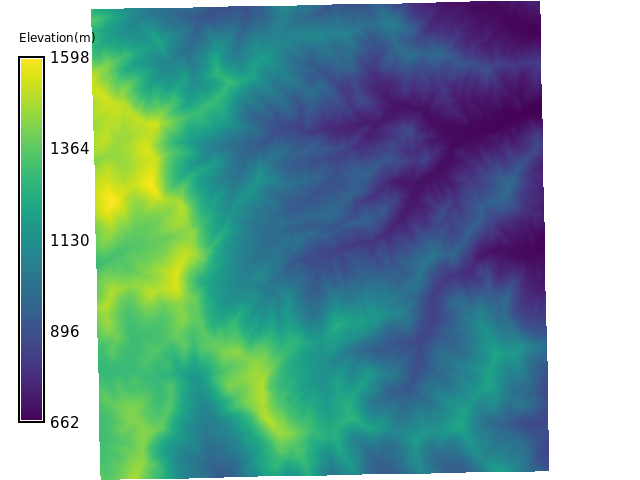

In [19]:
if not os.path.exists("image_map/dem"):
    gscript.read_command('r.in.gdal', flags='o', input=RawDEM, output="demRAW")
    gscript.parse_command('g.region', raster="demRAW", flags='p')
    gscript.run_command('d.rast', map="demRAW")
    gscript.run_command('d.legend', raster="demRAW", fontsize = '15', title = 'Elevation(m)', title_fontsize='12')
    os.mkdir("image_map/dem")
    shutil.move("map.png", "image_map/dem/map.png")
else:
    pass
Image(filename="image_map/dem/map.png")

### 5-2)  Reproejct DEM

In [20]:
gscript.read_command('r.out.gdal', input="demRAW", output="image_map/dem10m.tif", format="GTiff", overwrite=True)
gscript.read_command('r.in.gdal', flags='oe', input="image_map/dem10m.tif", output="dem")
gscript.parse_command('g.region', raster="dem", flags='p')

{u'cells:      446652': None,
 u'cols:       653': None,
 u'datum:      nad83': None,
 u'east:       279715.5645423': None,
 u'ellipsoid:  grs80': None,
 u'ewres:      10': None,
 u'north:      3884299.71357375': None,
 u'nsres:      10': None,
 u'projection: 1 (UTM)': None,
 u'rows:       684': None,
 u'south:      3877459.71357375': None,
 u'west:       273185.5645423': None,
 u'zone:       17': None}

### 5-3) Display weirs outlets in coweeta watershed

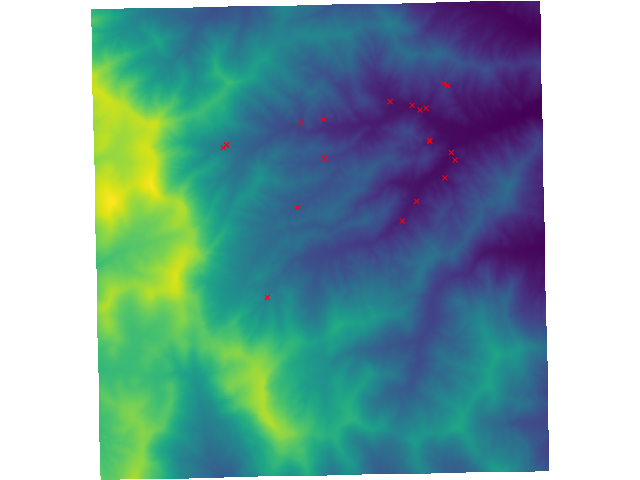

In [21]:
if not os.path.exists("image_map/outlet_points"):
    gscript.run_command('d.erase')
    gscript.run_command('v.in.ogr', input=WeirPoints, output="outlet", overwrite=True)
    gscript.run_command('d.rast', map="demRAW")
    gscript.run_command('d.vect', map="outlet", type="point", color="red")
    os.mkdir("image_map/outlet_points")
    shutil.move("map.png", "image_map/outlet_points/map.png")
else:
    pass
Image(filename="image_map/outlet_points/map.png")

In [22]:
# Display summary of weirs outlets in coweeta watershed
gscript.parse_command('v.info', map="outlet", flags='g')
print gscript.read_command('v.info', map="outlet")

 +----------------------------------------------------------------------------+
 | Name:            outlet                                                    |
 | Mapset:          PERMANENT                                                 |
 | Location:        coweeta_sub18                                             |
 | Database:        /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_pre |
 | Title:                                                                     |
 | Map scale:       1:1                                                       |
 | Name of creator: yc5ef                                                     |
 | Organization:                                                              |
 | Source date:     Thu Sep 12 04:08:31 2019                                  |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native              

In [23]:
# Display summary table of weirs outlets in coweeta watershed
#import pandas as pd
#from simpledbf import Dbf5

# Set raw data name from the list of gis_data directory above
#weir_points_data = 'coweeta_weirs_shp.dbf'
# Set each raw gis data using file directory and file name
#WeirPoints_db = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[0], resource_dir[0], weir_points_data)
#weirpoints_dbf = Dbf5(WeirPoints_db)
#weirpoints_df = weirpoints_dbf.to_dataframe()
#weirpoints_df.head()

### 5-4) Display weir outlet in sub18 of coweeta watershed

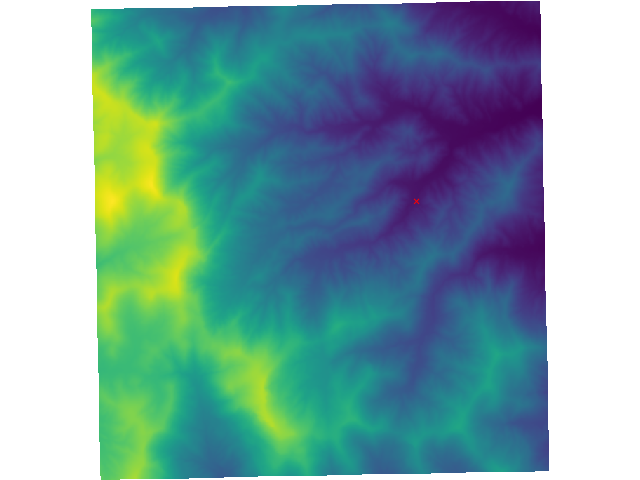

In [24]:
if not os.path.exists("image_map/outlet_point"):
    gscript.run_command('d.erase')
    gscript.run_command('v.extract', input="outlet", type="point", where="COMMENT = 'Weir 18'", output="gage", overwrite=True)
    gscript.run_command('d.rast', map="demRAW")
    gscript.run_command('d.vect', map="gage", type="point", color="red")
    os.mkdir("image_map/outlet_point")
    shutil.move("map.png", "image_map/outlet_point/map.png")
else:
    pass
Image(filename="image_map/outlet_point/map.png")

### 5-5) Delinearate coweeta subwatershed 18

In [25]:
# Imports vector data into a GRASS vector map using OGR library
gscript.run_command('v.in.ogr', input=WeirPoints, output="outlet", location="outletRAW", overwrite=True)
# Change location directory of GRASS to "outletRAW"
gsetup.init(GRASSEXE, GISDBASE, "outletRAW", MAPSET)
# Selects vector features from an existing vector map and creates a new vector map containing only the selected features
gscript.run_command('v.extract', input="outlet", type="point", where="COMMENT = 'Weir 18'", output="gage", overwrite=True)
# Change location directory of GRASS
gsetup.init(GRASSEXE, GISDBASE, LOCATION, MAPSET)
# Re-projects a vector map from one location to the current location
gscript.run_command('v.proj', location="outletRAW", mapset="PERMANENT", input="gage", output="outlet", overwrite=True)

0

In [26]:
#import wget
#url = "https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/grass_delineation.sh"
#wget.download(url, os.path.join(RLIB, "grass_delineation.sh"))

In [27]:
# Set parameters to delineater watershed
expectedDrainageArea = 120000 # meter squre 
RESOLUTION = 10
GRASS_thres = 100 # grid cell
GRASS_drainarea_lowerbound = 0.7*expectedDrainageArea/RESOLUTION/RESOLUTION # (recommend 2% error)
GRASS_drainarea_upperbound = 1.3*expectedDrainageArea/RESOLUTION/RESOLUTION # (recommend 2% error)

In [28]:
!wget -O {RLIB}/grass_delineation.sh https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/grass_delineation.sh

--2019-09-12 04:08:35--  https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/grass_delineation.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2005 (2.0K) [text/plain]
Saving to: ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/grass_delineation.sh’

/sfs/qumulo/qhome/y 100%[===================>]   1.96K  --.-KB/s    in 0s      

2019-09-12 04:08:35 (40.1 MB/s) - ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/grass_delineation.sh’ saved [2005/2005]



<div class="alert alert-block alert-info">
Create aspect, basin, hill, patch, slope, wetness_index, zone map with watershed delineation
</div>

### [Options 1] Python Use

In [32]:
import shlex
delineation_shell = os.path.join(RLIB, "grass_delineation.sh")
strings = ['bash', delineation_shell, str(GRASS_thres), str(GRASS_drainarea_lowerbound), str(GRASS_drainarea_upperbound)]
args = ' '.join(strings)
cmd = shlex.split(args)
p = gscript.Popen(cmd,  stdout=subprocess.PIPE)
output = p.communicate()[0].decode('utf-8')
print(output)

### [Options 2] Shell Script Use

In [29]:
!grass76 {location_path}/{MAPSET} --exec bash {RLIB}/grass_delineation.sh {GRASS_thres} {GRASS_drainarea_lowerbound} {GRASS_drainarea_upperbound}

Cleaning up temporary files...
access: No such file or directory
ERROR: LOCATION </home/yc5ef/grassdata/mylocation> not available
Starting GRASS GIS...
Executing <bash /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/grass_delineation.sh 100 840.0 1560.0> ...
ERROR: No existing MASK to remove
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
SECTION 1a (of 4): Initiating Memory.
SECTION 1b (of 4): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92 

### 5-6) Display map

#### - Aspect Map

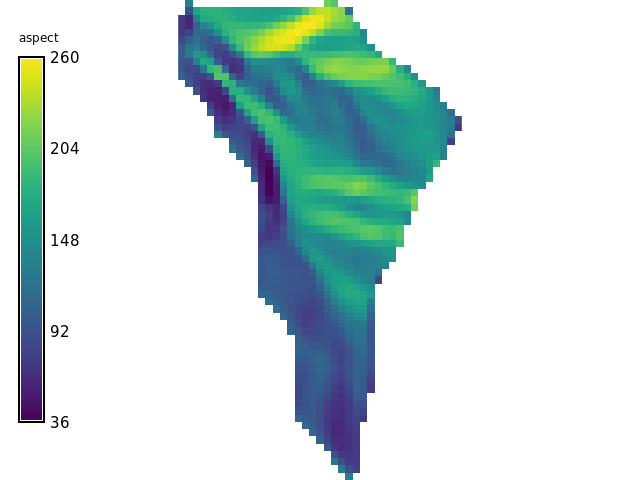

In [30]:
if not os.path.exists("image_map/aspect"):
    gscript.run_command('d.rast', map="aspect")
    gscript.run_command('d.legend', raster="aspect", fontsize = '15', title = 'aspect', title_fontsize='12')
    os.mkdir("image_map/aspect")
    shutil.move("map.png", "image_map/aspect/map.png")
else:
    pass
Image(filename="image_map/aspect/map.png")

#### - Drain Map

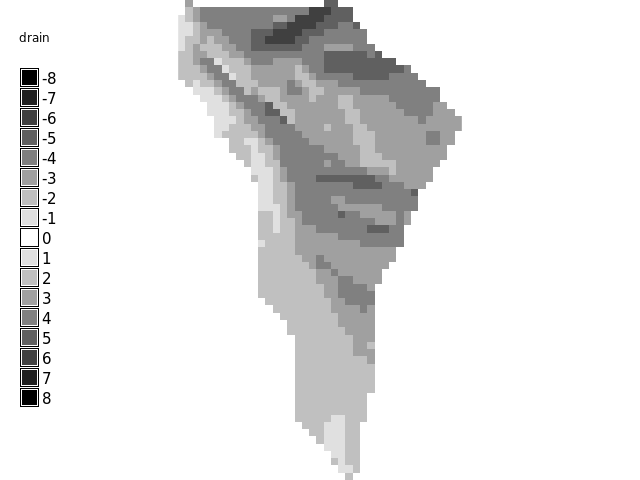

In [31]:
if not os.path.exists("image_map/drain"):
    gscript.run_command('d.rast', map="drain")
    gscript.run_command('d.legend', raster="drain", fontsize = '15', title = 'drain', title_fontsize='12')
    os.mkdir("image_map/drain")
    shutil.move("map.png", "image_map/drain/map.png")
else:
    pass
Image(filename="image_map/drain/map.png")

#### - Hill Map

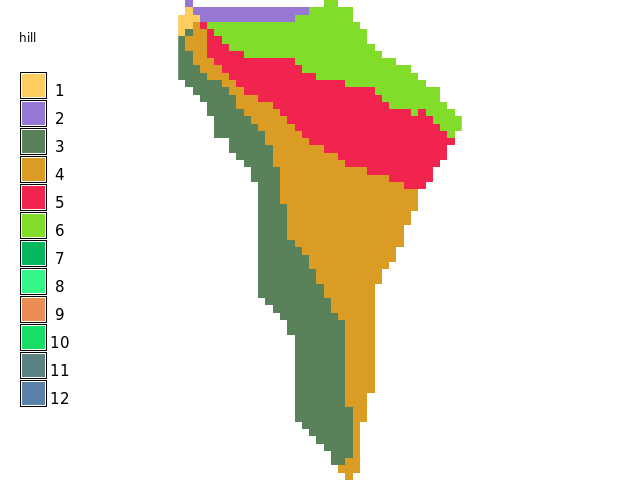

In [32]:
if not os.path.exists("image_map/hill"):
    gscript.run_command('d.rast', map="hill")
    gscript.run_command('d.legend', raster="hill", fontsize = '15', title = 'hill', title_fontsize='12')
    os.mkdir("image_map/hill")
    shutil.move("map.png", "image_map/hill/map.png")
else:
    pass
Image(filename="image_map/hill/map.png")

#### - Slope Map

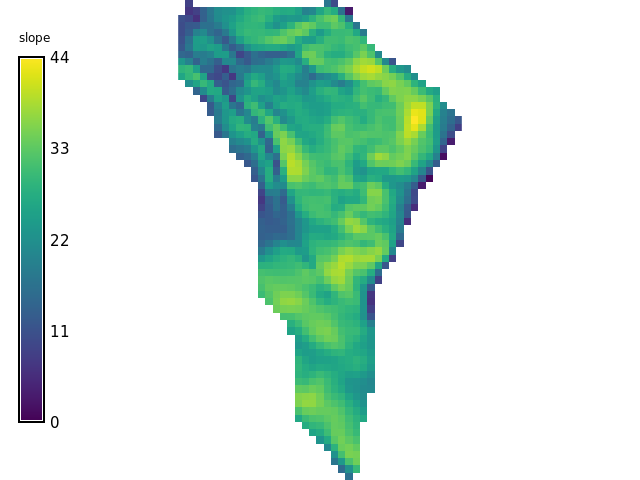

In [33]:
if not os.path.exists("image_map/slope"):
    gscript.run_command('d.rast', map="slope")
    gscript.run_command('d.legend', raster="slope", fontsize = '15', title = 'slope', title_fontsize='12')
    os.mkdir("image_map/slope")
    shutil.move("map.png", "image_map/slope/map.png")
else:
    pass
Image(filename="image_map/slope/map.png")

#### - Zone Map

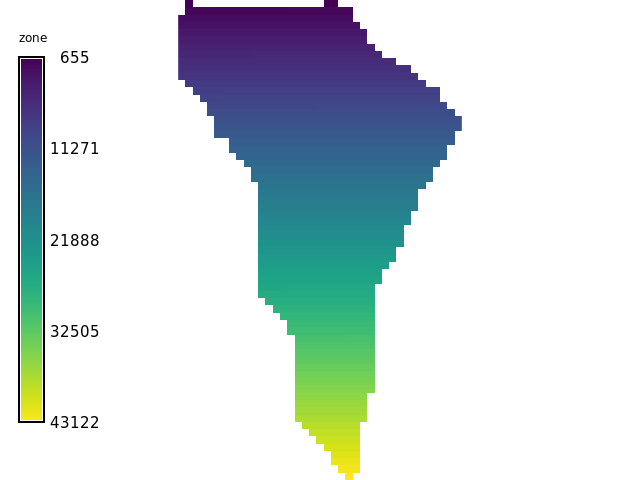

In [34]:
if not os.path.exists("image_map/zone"):
    gscript.run_command('d.rast', map="zone")
    gscript.run_command('d.legend', raster="zone", fontsize = '15', title = 'zone', title_fontsize='12')
    os.mkdir("image_map/zone")
    shutil.move("map.png", "image_map/zone/map.png")
else:
    pass
Image(filename="image_map/zone/map.png")

#### - Patch Map

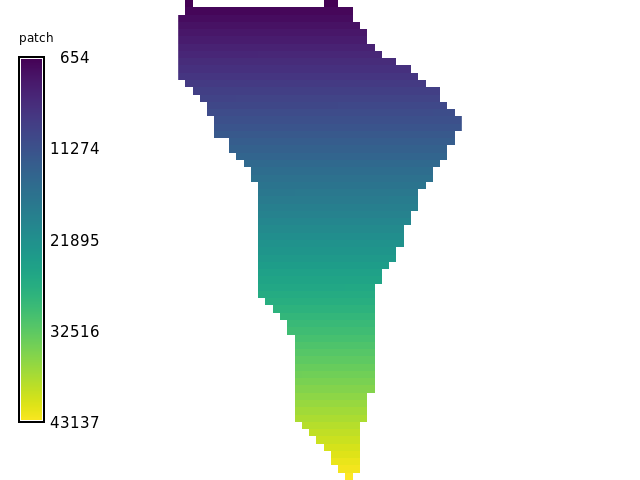

In [35]:
if not os.path.exists("image_map/patch"):
    gscript.run_command('d.rast', map="patch")
    gscript.run_command('d.legend', raster="patch", fontsize = '15', title = 'patch', title_fontsize='12')
    os.mkdir("image_map/patch")
    shutil.move("map.png", "image_map/patch/map.png")
else:
    pass
Image(filename="image_map/patch/map.png")

#### - Wetness Index Map

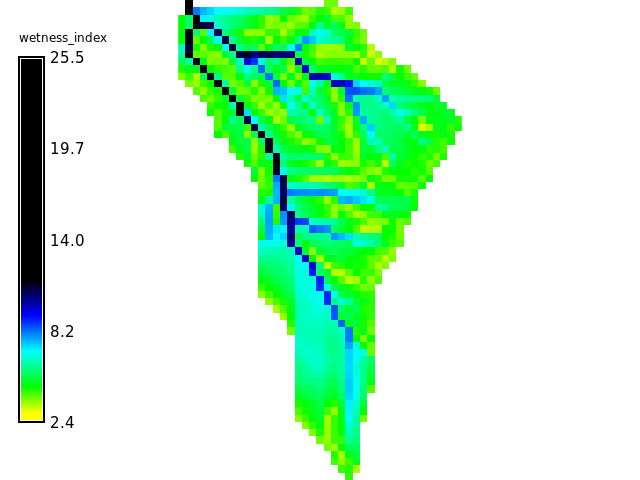

In [36]:
if not os.path.exists("image_map/wetness_index"):
    gscript.run_command('d.rast', map="wetness_index")
    gscript.run_command('d.legend', raster="wetness_index", fontsize = '15', title = 'wetness_index', title_fontsize='12')
    os.mkdir("image_map/wetness_index")
    shutil.move("map.png", "image_map/wetness_index/map.png")
else:
    pass
Image(filename="image_map/wetness_index/map.png")

## 6) Importing and Processing NLCD Map

In [37]:
# Imports raster data into a GRASS raster map using GDAL library
if not os.path.exists("RHESsys_preprocessing/grassdata/lulcRAW"):
    gscript.read_command('r.in.gdal', input=RawNLCD, output="lulcRAW", location="lulcRAW", overwrite=True, flags="e")
else:
    pass
# Exports GRASS raster maps into GDAL supported formats
gsetup.init(GRASSEXE, GISDBASE, "lulcRAW", MAPSET)
gscript.read_command('r.out.gdal', input="lulcRAW", output="image_map/LULC10m.tif", format="GTiff", overwrite=True)
# Imports raster data into a GRASS raster map using GDAL library
gsetup.init(GRASSEXE, GISDBASE, LOCATION, MAPSET)
gscript.read_command('r.in.gdal', input="image_map/LULC10m.tif", output="LULCcode", overwrite=True, flags="o")

''

In [38]:
print gscript.read_command('r.report', map="LULCcode", unit='c,k,p')

+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: coweeta_sub18                              Thu Sep 12 04:09:06 2019|
|-----------------------------------------------------------------------------|
|          north: 3881439.71357375    east: 278205.5645423                    |
|REGION    south: 3880779.71357375    west: 277815.5645423                    |
|          res:                 10    res:              10                    |
|-----------------------------------------------------------------------------|
|MASK: basin in PERMANENT, categories 1                                       |
|-----------------------------------------------------------------------------|
|MAP: (untitled) (LULCcode in PERMANENT)                                      |
|-----------------------------------------------------------------------------|
|                Category Information   

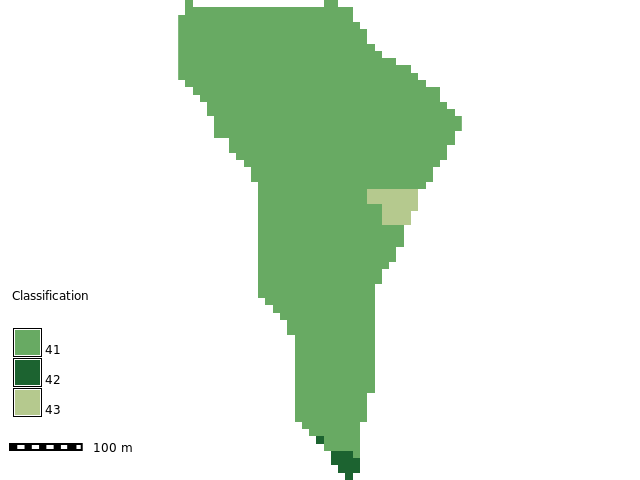

In [39]:
gscript.run_command('d.erase')
if not os.path.exists("image_map/NLCD"):
    gscript.run_command('d.rast', map="LULCcode")
    gscript.run_command('d.barscale')
    gscript.run_command('d.legend', raster="LULCcode", fontsize = '12', title = 'Classification', 
                        title_fontsize='12', use='41,42,43', at="10,35,2,5")
    gscript.run_command('r.category', map="LULCcode", rules="nlcd.txt", separator=":")
    os.mkdir("image_map/NLCD")
    shutil.move("map.png", "image_map/NLCD/map.png")
else:
    pass
Image(filename="image_map/NLCD/map.png")

</div>
- Stratum information (see https://github.com/laurencelin/GIS2RHESSys/blob/master/vegCollection.csv)
    - stratum vegetation ID (users define)
    - stratum cover fraction (users define)
    - stratum LAI (users define)
- Landuse object
    - landuse type (ID) (users define) that associates with the following information (see https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/soilCollection.csv): 
        - surface detention storage capacity 
        - annual areal fertilizer rate

In [40]:
%%writefile {RLIB}/LULC2RHESSys.R
options(scipen=999)
library(sp)
library(XML)
library(rgrass7)
rast = readRAST(c('basin','str','LULCcode'))
mask = !is.na(rast@data[[1]])
str = rast@data[[2]][mask]
lulc = rast@data[[3]][mask]

rast$vegid = rep(NA,length(mask))
rast$landuse = rep(NA,length(mask))
rast$lai = rep(NA,length(mask))
rast$impervious = rep(NA,length(mask))
rast$coverFrac = rep(NA,length(mask))

#--- forest
    cond=(lulc==41 | lulc==43 | lulc==90 | lulc==95) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(2) # deciduous @ vegCollection.csv
    rast$landuse[mask][cond] = as.integer(2) # undeveloped @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 1.0
    rast$lai[mask][cond] = 4.5
    rast$impervious[mask][cond] = 0.0

    cond=(lulc==42) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(1) # evergreen @ vegCollection.csv 
    rast$landuse[mask][cond] = as.integer(2) # undeveloped @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 1.0
    rast$lai[mask][cond] = 5.0
    rast$impervious[mask][cond] = 0.0

    cond=(lulc==51 | lulc==52) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(6) # shrub @ vegCollection.csv 
    rast$landuse[mask][cond] = as.integer(2) # undeveloped @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 1.0
    rast$lai[mask][cond] = 2
    rast$impervious[mask][cond] = 0.0

#--- pasture / grass / agriculture 
    cond=(lulc==71 | lulc==72 | lulc==81 | lulc==82) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(3) # grass @ vegCollection.csv 
    rast$landuse[mask][cond] = as.integer(1) # grass @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 1.0
    rast$lai[mask][cond] = 1.5
    rast$impervious[mask][cond] = 0.0

#--- urban / barren
    cond=(lulc==31) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(6) # shrub @ vegCollection.csv (may vary by state/county/city/local)
    rast$landuse[mask][cond] = as.integer(2) # undeveloped @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 0.15 # 15% grass/lawn
    rast$lai[mask][cond] = 3.0
    rast$impervious[mask][cond] = 0.85

    cond=(lulc==21) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(3) # grass @ vegCollection.csv (may vary by state/county/city/local)
    rast$landuse[mask][cond] = as.integer(3) # urban @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 0.8 # 80% grass/lawn
    rast$lai[mask][cond] = 1.5
    rast$impervious[mask][cond] = 0.2

    cond=(lulc==22) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(3) # grass @ vegCollection.csv (may vary by state/county/city/local)
    rast$landuse[mask][cond] = as.integer(3) # urban @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 0.5 # 50% grass/lawn
    rast$lai[mask][cond] = 1.5
    rast$impervious[mask][cond] = 0.5

    cond=(lulc==23) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(3) # grass @ vegCollection.csv (may vary by state/county/city/local)
    rast$landuse[mask][cond] = as.integer(3) # urban @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 0.2 # 20% grass/lawn
    rast$lai[mask][cond] = 1.5
    rast$impervious[mask][cond] = 0.8

    cond=(lulc==24) & is.na(str); 
    rast$vegid[mask][cond] = as.integer(4) # no-veg @ vegCollection.csv (may vary by state/county/city/local)
    rast$landuse[mask][cond] = as.integer(3) # urban @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 1.0
    rast$lai[mask][cond] = 1.0
    rast$impervious[mask][cond] = 1.0

    cond= !is.na(str); 
    rast$vegid[mask][cond] = as.integer(4) # no-veg @ vegCollection.csv (may vary by state/county/city/local)
    rast$landuse[mask][cond] = as.integer(2) # undeveloped @ lulcCollection.csv
    rast$coverFrac[mask][cond] = 1.0
    rast$lai[mask][cond] = 0.0
    rast$impervious[mask][cond] = 0.0

writeRAST(rast,'vegid',zcol='vegid',overwrite=T)
writeRAST(rast,'landuse',zcol='landuse',overwrite=T)
writeRAST(rast,'coverFrac',zcol='coverFrac',overwrite=T)
writeRAST(rast,'lai',zcol='lai',overwrite=T)
writeRAST(rast,'impervious',zcol='impervious',overwrite=T)

Writing /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/LULC2RHESSys.R


In [41]:
print gscript.read_command('r.info', map="basin")

 +----------------------------------------------------------------------------+
 | Map:      basin                          Date: Thu Sep 12 04:08:50 2019    |
 | Mapset:   PERMANENT                      Login of Creator: yc5ef           |
 | Location: coweeta_sub18                                                    |
 | DataBase: /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocess |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    CELL                                                       |
 |   Rows:         66                                                         |
 |   Columns:      39                   

In [42]:
print gscript.read_command('r.info', map="str")

 +----------------------------------------------------------------------------+
 | Map:      str                            Date: Thu Sep 12 04:08:50 2019    |
 | Mapset:   PERMANENT                      Login of Creator: yc5ef           |
 | Location: coweeta_sub18                                                    |
 | DataBase: /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocess |
 | Title:    Watershed stream segments                                        |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    CELL                                                       |
 |   Rows:         66                                                         |
 |   Columns:      39                   

In [43]:
print gscript.read_command('r.info', map="LULCcode")

 +----------------------------------------------------------------------------+
 | Map:      LULCcode                       Date: Thu Sep 12 04:09:05 2019    |
 | Mapset:   PERMANENT                      Login of Creator: yc5ef           |
 | Location: coweeta_sub18                                                    |
 | DataBase: /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocess |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 43              |
 |   Data Type:    CELL                                                       |
 |   Rows:         684                                                        |
 |   Columns:      653                  

### [Options 1] Python Use

In [58]:
import shlex
lulc_r = os.path.join(RLIB, "LULC2RHESSys.R")
strings = ['Rscript', lulc_r]
args = ' '.join(strings)
cmd = shlex.split(args)
p = gscript.Popen(cmd, stdout=subprocess.PIPE)
output = p.communicate()[0].decode('utf-8')
print(output)

Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  

### [Options 2] Shell Script Use

In [44]:
!grass76 {location_path}/{MAPSET} --exec Rscript {RLIB}/LULC2RHESSys.R

Cleaning up temporary files...
access: No such file or directory
ERROR: LOCATION </home/yc5ef/grassdata/mylocation> not available
Starting GRASS GIS...
Executing <Rscript /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/LULC2RHESSys.R> ...
GRASS GIS interface loaded with GRASS version: GRASS 7.6.1 (2019)
and location: coweeta_sub18
Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0 

In [45]:
# 
gscript.parse_command('g.list', type='rast', flags='p')

{u'': None,
 u'----------------------------------------------': None,
 u'LULCcode        basin           east_000        rowmap          vegid': None,
 u'MASK            colmap          hill            slope           west_180': None,
 u'ONE             coverFrac       impervious      slope_          wetness_index': None,
 u'ZERO            dem             lai             str             xmap': None,
 u'aspect          demRAW          landuse         sub             ymap': None,
 u'aspect_         drain           patch           uaa             zone': None,
 u'raster files available in mapset <PERMANENT>:': None}

In [46]:
!grass76 {location_path}/{MAPSET} --exec g.list -p type='rast' | cat

Cleaning up temporary files...
access: No such file or directory
ERROR: LOCATION </home/yc5ef/grassdata/mylocation> not available
Starting GRASS GIS...
Executing <g.list -p type=rast> ...
----------------------------------------------
raster files available in mapset <PERMANENT>:
LULCcode        basin           east_000        rowmap          vegid
MASK            colmap          hill            slope           west_180
ONE             coverFrac       impervious      slope_          wetness_index
ZERO            dem             lai             str             xmap
aspect          demRAW          landuse         sub             ymap
aspect_         drain           patch           uaa             zone

Execution of <g.list -p type=rast> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


## 7) Importing and Processing Soil Map

<div class="alert alert-block alert-info">
SSURGO Soil data is often used to build RHESSys model. Note that there is no SSURGO data in the HydroShare resource for this catchment yet.
</div>

In [47]:
## set path to ssurgo data and import to native projection
gscript.run_command('v.in.ogr', input=RawSSURGO, output="ssurgo", location="soilRAW", overwrite=True)
## reproject ssurgo polygons to project projection
gscript.run_command('v.proj', location="soilRAW", mapset="PERMANENT", input="ssurgo", output="ssurgo", overwrite=True)
## rasterize it
gscript.run_command('v.to.rast', input="ssurgo", use="cat", output="soil_ssurgo", overwrite=True)
## extract mukey and cat ID
soil_cat_mukey = os.path.join(RHESSysDIR, "soil_cat_mukey.csv")
gscript.run_command('v.db.select', map="ssurgo", separator="comma", file=soil_cat_mukey)

0

In [48]:
## download R scripts to calculation soil types
!wget -O {RLIB}/ssurgo_extraction.R https://raw.githubusercontent.com/laurencelin/ssurgo_extraction/master/ssurgo_extraction.R
!wget -O {RLIB}/ssurgo_soiltexture2gis.R https://raw.githubusercontent.com/laurencelin/ssurgo_extraction/master/ssurgo_soiltexture2gis.R

--2019-09-12 04:09:52--  https://raw.githubusercontent.com/laurencelin/ssurgo_extraction/master/ssurgo_extraction.R
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15220 (15K) [text/plain]
Saving to: ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/ssurgo_extraction.R’

/sfs/qumulo/qhome/y 100%[===================>]  14.86K  --.-KB/s    in 0.002s  

2019-09-12 04:09:52 (6.10 MB/s) - ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/ssurgo_extraction.R’ saved [15220/15220]

--2019-09-12 04:09:52--  https://raw.githubusercontent.com/laurencelin/ssurgo_extraction/master/ssurgo_soiltexture2gis.R
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.

In [49]:
# Set raw data name from the list of gis_data directory above
soil_data3 = 'wss_aoi'
# Set each raw gis data using file directory and file name
RawSSURGO = os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0], soil_data3)
RawSSURGO

'/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/raw_data/Coweeta_sub18/gis_data/wss_aoi'

### [Options 1] Python Use

In [93]:
import shlex
ssurgo_r = os.path.join(RLIB, "ssurgo_extraction.R")
strings = ['Rscript', ssurgo_r, RawSSURGO]
args = ' '.join(strings)
cmd = shlex.split(args)
p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
output = p.communicate()[0].decode('utf-8')
print(output)

In [94]:
import shlex
ssurgo_soiltexture2gis = os.path.join(RLIB, "ssurgo_soiltexture2gis.R")
soil_cat_mukey = os.path.join(RHESSysDIR, "soil_cat_mukey.csv")
soil_mukey_texture = os.path.join(RawSSURGO, "soil_mukey_texture.csv")
strings = ['Rscript', ssurgo_soiltexture2gis, soil_cat_mukey, soil_mukey_texture]
args = ' '.join(strings)
cmd = shlex.split(args)
p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
output = p.communicate()[0].decode('utf-8')
print(output)

Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  7

### [Options 2] Shell Script Use

In [50]:
## calling R tool to linking tabular dataset; it outputs "$PROJDIR/$RHESSysNAME/soil_cat_mukey.csv"
!Rscript {RLIB}/ssurgo_extraction.R {RawSSURGO}

In [51]:
## calling R tool to import information back to GRASS (7.4)
!grass76 {location_path}/{MAPSET} --exec Rscript {RLIB}/ssurgo_soiltexture2gis.R {RHESSysDIR}/soil_cat_mukey.csv {RawSSURGO}/soil_mukey_texture.csv

Cleaning up temporary files...
access: No such file or directory
ERROR: LOCATION </home/yc5ef/grassdata/mylocation> not available
Starting GRASS GIS...
Executing <Rscript /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/ssurgo_soiltexture2gis.R /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/soil_cat_mukey.csv /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/raw_data/Coweeta_sub18/gis_data/wss_aoi/soil_mukey_texture.csv> ...
Loading required package: sp
Loading required package: XML
GRASS GIS interface loaded with GRASS version: GRASS 7.6.1 (2019)
and location: coweeta_sub18
Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100

In [52]:
print gscript.read_command('r.report', map="soil_texture", unit='c,k,p')

+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: coweeta_sub18                              Thu Sep 12 04:10:06 2019|
|-----------------------------------------------------------------------------|
|          north: 3881439.71357375    east: 278205.5645423                    |
|REGION    south: 3880779.71357375    west: 277815.5645423                    |
|          res:                 10    res:              10                    |
|-----------------------------------------------------------------------------|
|MASK: basin in PERMANENT, categories 1                                       |
|-----------------------------------------------------------------------------|
|MAP: (untitled) (soil_texture in PERMANENT)                                  |
|-----------------------------------------------------------------------------|
|                Category Information   

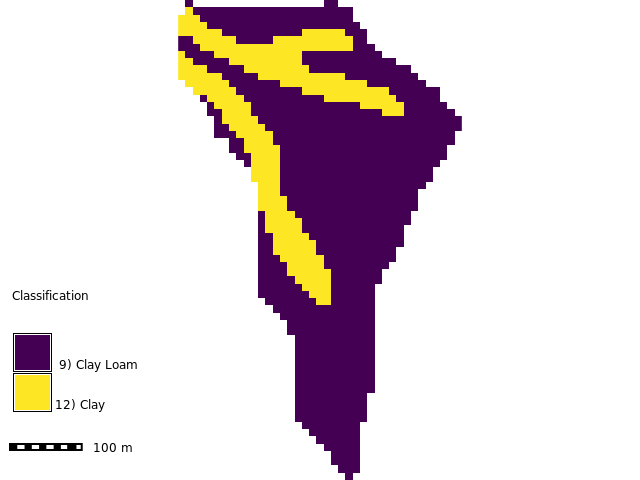

In [54]:
gscript.run_command('d.erase')
if not os.path.exists("image_map/soil"):
    gscript.run_command('d.rast', map="soil_texture")
    gscript.run_command('d.barscale')
    gscript.run_command('d.legend', raster="soil_texture", fontsize = '12', title = 'Classification', 
                        title_fontsize='12', use='9,12', at="10,35,2,5")
    gscript.run_command('r.category', map="soil_texture", rules="soil_texture.txt", separator=":")
    os.mkdir("image_map/soil")
    shutil.move("map.png", "image_map/soil/map.png")
else:
    pass
Image(filename="image_map/soil/map.png")

## 8) Importing and Processing Road network / Isohyet

<div class="alert alert-block alert-info">
Define road network. Note that we must define a road raster map for w2g and flowtable calculation. So define a null road raster (below) if there is no road.
</div>

<div class="alert alert-block alert-success">
make an empty road map.  Compare raw gis road map and this created road map
</div>

In [55]:
!grass76 {location_path}/{MAPSET} --exec r.mapcalc --overwrite expression="roads = null()"

Cleaning up temporary files...
access: No such file or directory
ERROR: LOCATION </home/yc5ef/grassdata/mylocation> not available
Starting GRASS GIS...
Executing <r.mapcalc --overwrite expression=roads = null()> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
Execution of <r.mapcalc --overwrite expression=roads = null()> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


<div class="alert alert-block alert-info">
Define isohyet. Note that we must define a road raster map for w2g and flowtable calculation. 
</div>

<div class="alert alert-block alert-success">
no isohyet
</div>

In [56]:
!grass76 {location_path}/{MAPSET} --exec r.mapcalc --overwrite expression="isohyet = 1"

Cleaning up temporary files...
access: No such file or directory
ERROR: LOCATION </home/yc5ef/grassdata/mylocation> not available
Starting GRASS GIS...
Executing <r.mapcalc --overwrite expression=isohyet = 1> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96 100
Execution of <r.mapcalc --overwrite expression=isohyet = 1> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


## 9) Construct worldfile and flowtable to RHESSys

### 9-1) [Option 1] No clim, defs and obs data in raw data

- Creating Pandas DataFrame from Daily Observation csv file

In [57]:
import pandas as pd
import numpy as np
import os, shutil

In [58]:
obs_clim = pd.read_csv('climate_coweeta_ws18.csv')
obs_clim.head()

,date,rain,tmax,tmin,vpd,rh,kdownDirect
0,9/1/1983,0.0010,25.6,13.9,256.58,88.8,13233.7
1,9/2/1983,0.0081,20.6,15.0,186.72,91.2,3564.7
2,9/3/1983,0.0061,22.2,16.7,203.78,90.7,5004
3,9/4/1983,0.0521,25.6,16.7,267.17,89.1,10217.1
4,9/5/1983,0.0010,29.4,17.8,441.04,84,16727.3


- Creating RHESsys input from Timeseries data

In [59]:
ClimDIR = os.path.join(RHESSysDIR, 'clim')
os.mkdir(ClimDIR)

In [60]:
rain = obs_clim['rain'].values
np.savetxt(r'cwt.rain', obs_clim['rain'].values, fmt='%2.4f', header='1983 9 1 1', comments='')
shutil.move('cwt.rain', ClimDIR)

In [61]:
tmax = obs_clim['tmax'].values
np.savetxt(r'cwt.tmax', obs_clim['tmax'].values, fmt='%2.1f', header='1983 9 1 1', comments='')
shutil.move('cwt.tmax', ClimDIR)

In [62]:
tmin = obs_clim['tmin'].values
np.savetxt(r'cwt.tmin', obs_clim['tmin'].values, fmt='%2.1f', header='1983 9 1 1', comments='')
shutil.move('cwt.tmin', ClimDIR)

In [63]:
vpd = pd.to_numeric(obs_clim['vpd'].values, errors='coerce')
np.savetxt(r'cwt.vpd', vpd, fmt='%3.2f', header='1983 9 1 1', comments='')
shutil.move('cwt.vpd', ClimDIR)

In [64]:
rh = pd.to_numeric(obs_clim['rh'].values, errors='coerce')
np.savetxt(r'cwt.relative_humidity', rh, fmt='%2.1f', header='1983 9 1 1', comments='')
shutil.move('cwt.relative_humidity', ClimDIR)

In [65]:
kdownDirect = pd.to_numeric(obs_clim['kdownDirect'].values, errors='coerce')
np.savetxt(r'cwt.Kdown_direct', kdownDirect, fmt='%5.1f', header='1983 9 1 1', comments='')
shutil.move('cwt.Kdown_direct', ClimDIR)

In [66]:
cwt_path = ClimDIR +"/cwt"
cwt_path

'/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/clim/cwt'

In [67]:
base = open("cwt.base","w") 
contents = ["101 base_station_id \n",
     "278391.71 x_coordinate \n",
     "3882439.5 y_coordinate \n",
     "638.0 z_coordinate \n",
     "2.0 effective_lai \n",
     "22.9 	screen_height \n",
     cwt_path + " daily_climate_prefix \n",
     "0 ",]  
base.writelines(contents) 
base.close() 
shutil.move('cwt.base', ClimDIR)

In [68]:
climateBaseFile = os.path.join(ClimDIR, 'cwt.base')

- Creating defs data folder

In [69]:
defsDIR = os.path.join(RHESSysDIR, 'defs')
os.mkdir(defsDIR)

- Creating tecfiles data folder

In [70]:
tecfilessDIR = os.path.join(RHESSysDIR, 'tecfiles')
os.mkdir(tecfilessDIR)

In [71]:
tec_daily = open("tec_daily.txt","w") 
contents = ["1983 9 1 1 print_daily_on "]  
tec_daily.writelines(contents) 
tec_daily.close() 
shutil.move('tec_daily.txt', tecfilessDIR)

- Creating obs data folder and import data

In [72]:
ObsDIR = os.path.join(RHESSysDIR, 'obs')
os.mkdir(ObsDIR)

In [73]:
shutil.copy('streamflow_coweeta_ws18.csv', ObsDIR)

In [74]:
obs_flow = pd.read_csv(os.path.join(ObsDIR, 'streamflow_coweeta_ws18.csv'))
obs_flow.head()

,Year,Month,Day,date,discharge (mm)
0,1936,11,1,11/1/1936,0.850
1,1936,11,2,11/2/1936,0.850
2,1936,11,3,11/3/1936,0.850
3,1936,11,4,11/4/1936,1.615
4,1936,11,5,11/5/1936,1.124


### 9-1) [Option 2] In case of data existence of clim, defs and obs in raw data

Description of worldfile and flowtable

<div class="alert alert-block alert-success">
Copy climate series data from HydroShare download (we use this option in this example)
</div>

In [67]:
from os import listdir 
from distutils.dir_util import copy_tree

In [ ]:
copy_tree(os.path.join(RAWGISDIR, os.listdir(RAWGISDIR)[1], resource_dir[0]), RHESSysDIR)

In [61]:
onlyfiles = [f for f in listdir(RHESSysDIR+'/clim') if f.endswith(".base")]
onlyfiles

['._cwt.base', 'cwt.base']

In [62]:
climateBaseFile = RHESSysDIR+'/clim/'+onlyfiles[1]
climateBaseFile

'/data/hsjupyter/a/davidchoi76/grassgis/RHESsys_preprocessing/model/clim/cwt.base'

In [63]:
with open(climateBaseFile) as clim:
    line = clim.readline()
    climateBaseID = line.split(" ")[0]

In [64]:
import fileinput
import sys

def replaceAll(file, searchExp, replaceExp):
    for line in fileinput.input(file, inplace=1):
        if searchExp in line:
            line = line.replace(searchExp,replaceExp)
        sys.stdout.write(line)
replaceAll(climateBaseFile, 'clim/'+onlyfiles[1].split(".")[0], climateBaseFile.split(".")[0])

### 9-2) Download "g2w_Rivanna.R","vegCollection.csv","soilCollection.csv", and "lulcCollection.csv" from github

In [75]:
# Download "g2w_Rivanna.R","vegCollection.csv","soilCollection.csv", and "lulcCollection.csv" from github
!wget -O {RLIB}/g2w_Rivanna.R https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/g2w_Rivanna.R
!wget -O {RLIB}/vegCollection.csv https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/vegCollection.csv
!wget -O {RLIB}/soilCollection.csv https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/soilCollection.csv
!wget -O {RLIB}/lulcCollection.csv https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/lulcCollection.csv

--2019-09-12 04:11:22--  https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/g2w_Rivanna.R
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17356 (17K) [text/plain]
Saving to: ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/g2w_Rivanna.R’

/sfs/qumulo/qhome/y 100%[===================>]  16.95K  --.-KB/s    in 0.002s  

2019-09-12 04:11:22 (6.95 MB/s) - ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/g2w_Rivanna.R’ saved [17356/17356]

--2019-09-12 04:11:22--  https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/vegCollection.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.


### 9-3) create worldfiles and definition files

In [76]:
climateBaseID = 101

In [85]:
# Create definition file using Rscript
!grass76 {location_path}/{MAPSET} --exec Rscript {RLIB}/g2w_Rivanna.R {PROJDIR} {climateBaseID} {climateBaseFile} {RLIB}/vegCollection.csv {RLIB}/soilCollection.csv {RLIB}/lulcCollection.csv {RHESSysDIR}/worldfiles/worldfile.csv {RHESSysDIR}/worldfiles/worldfile.hdr {RHESSysDIR}/defs

Cleaning up temporary files...
access: No such file or directory
ERROR: LOCATION </home/yc5ef/grassdata/mylocation> not available
Starting GRASS GIS...
Executing <Rscript /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/g2w_Rivanna.R /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing 101 /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/clim/cwt.base /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/vegCollection.csv /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/soilCollection.csv /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/lulcCollection.csv /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/worldfiles/worldfile.csv /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/worldfiles/worldfile.hdr /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/defs> ...
Loading required package

In [78]:
# Download "LIB_RHESSys_writeTable2World.R" from github
!wget -O {RLIB}/LIB_RHESSys_writeTable2World.R https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/LIB_RHESSys_writeTable2World.R

--2019-09-12 04:11:51--  https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/LIB_RHESSys_writeTable2World.R
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18725 (18K) [text/plain]
Saving to: ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/LIB_RHESSys_writeTable2World.R’

/sfs/qumulo/qhome/y 100%[===================>]  18.29K  --.-KB/s    in 0.002s  

2019-09-12 04:11:51 (7.19 MB/s) - ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/LIB_RHESSys_writeTable2World.R’ saved [18725/18725]



<div class="alert alert-block alert-info">
convert extracted worldfile.csv to RHESSys worldfile format.
</div>

In [79]:
# Create worldfile.csv and worldfile using Rscript
!Rscript {RLIB}/LIB_RHESSys_writeTable2World.R na {RHESSysDIR}/worldfiles/worldfile.csv {RHESSysDIR}/worldfiles/worldfile

[1] "header = na"
[1] "basefile = /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/worldfiles/worldfile.csv"
[1] "outputfile = /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/worldfiles/worldfile"


### 9-4) create flow table

In [80]:
# Download "createFlowRouting.r" from github
!wget -O {RLIB}/createFlowRouting.r https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/createFlowRouting.r

--2019-09-12 04:12:14--  https://raw.githubusercontent.com/laurencelin/GIS2RHESSys/master/libraries/createFlowRouting.r
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10545 (10K) [text/plain]
Saving to: ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/createFlowRouting.r’

/sfs/qumulo/qhome/y 100%[===================>]  10.30K  --.-KB/s    in 0s      

2019-09-12 04:12:14 (115 MB/s) - ‘/sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/createFlowRouting.r’ saved [10545/10545]



<div class="alert alert-block alert-info">
(subsurface) flow table calculation 
</div>

In [81]:
# Create flowtable.txt and worldfile using Rscript
!grass76 {location_path}/{MAPSET} --exec Rscript {RLIB}/createFlowRouting.r {RHESSysDIR}/flows/flowtable.txt

Cleaning up temporary files...
access: No such file or directory
ERROR: LOCATION </home/yc5ef/grassdata/mylocation> not available
Starting GRASS GIS...
Executing <Rscript /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/RLIB/createFlowRouting.r /sfs/qumulo/qhome/yc5ef/rhessys_preprocessing/RHESsys_preprocessing/model/flows/flowtable.txt> ...
GRASS GIS interface loaded with GRASS version: GRASS 7.6.1 (2019)
and location: coweeta_sub18
rgdal: version: 1.4-3, (SVN revision 828)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.2, released 2017/09/15
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 
Creating BIL support files...
Exporting raster as integer values (bytes=4)
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45 

### 9-5) verifiy output

In [82]:
ls -l {RLIB}

total 144
-rw-r--r-- 1 yc5ef users 10545 Sep 12 04:12 createFlowRouting.r
-rw-r--r-- 1 yc5ef users 17356 Sep 12 04:11 g2w_Rivanna.R
-rw-r--r-- 1 yc5ef users  2005 Sep 12 04:08 grass_delineation.sh
-rw-r--r-- 1 yc5ef users 18725 Sep 12 04:11 LIB_RHESSys_writeTable2World.R
-rw-r--r-- 1 yc5ef users  3978 Sep 12 04:09 LULC2RHESSys.R
-rw-r--r-- 1 yc5ef users   450 Sep 12 04:11 lulcCollection.csv
-rw-r--r-- 1 yc5ef users  5796 Sep 12 04:11 soilCollection.csv
-rw-r--r-- 1 yc5ef users 15220 Sep 12 04:09 ssurgo_extraction.R
-rw-r--r-- 1 yc5ef users  2149 Sep 12 04:09 ssurgo_soiltexture2gis.R
-rw-r--r-- 1 yc5ef users 13150 Sep 12 04:11 vegCollection.csv


In [83]:
ls -lh {RHESSysDIR}/flows

total 268K
-rw-r--r-- 1 yc5ef users 264K Sep 12 04:12 flowtable.txt


In [84]:
ls -lh {RHESSysDIR}/worldfiles

total 6.5M
-rw-r--r-- 1 yc5ef users 5.6M Sep 12 04:12 worldfile
-rw-r--r-- 1 yc5ef users 886K Sep 12 04:11 worldfile.csv
-rw-r--r-- 1 yc5ef users  899 Sep 12 04:11 worldfile.hdr


## Move to 2. RHESsys Model Simulation Notebook

[2_RHESsys Model Simulation on Collaborative Modeling Framework.ipynb](./2_RHESsys_Model_Simulation_on_Collaborative_Modeling_Framework.ipynb)
    